# Dilla-Digger: Predicting Music Samples Based on Audio Features

Predict audio features based on Dilla's sampled tracks and use those audio feature predictions to plug into Spotify API recommendation endpoint https://developer.spotify.com/documentation/web-api/reference/get-recommendations

Anoop Patta

## Introduction

A crate digger is defined as "a person who habitually looks through crates of vinyl records at music shops, especially in pursuit of rare or interesting albums". DillaDigger aims to predict and bring light to rare or interesting music.

In [1]:
# imports
import requests
import os
import pandas as pd
from bs4 import BeautifulSoup
import re
import base64
import matplotlib.pyplot as plt
import numpy as np
import os
from dotenv import load_dotenv

In [2]:
# Load the Spotify variables Client ID and Client Secret from the .env file
# Get spotify credentials here: https://developer.spotify.com/
load_dotenv()

client_id = os.environ.get("CLIENT_ID")
client_secret = os.environ.get("CLIENT_SECRET")

## Data Collection

Load in data from https://www.whosampled.com/J-Dilla/samples/

In [3]:
dillaSamples = pd.DataFrame(columns=['song_name', 'artists', 'year'])  # Creating an empty DataFrame

# loop through the html files
for i in range(1, 51):
    filename = f"raw/whosampled/{i}.html"
    with open(filename, 'r') as f:
        # scrape using BeautifulSoup
        content = f.read()
        soup = BeautifulSoup(content, "html.parser")
        track_connections = soup.find_all('div', class_='track-connection')

        # Clean the text using regex to match out column names
        pattern = r"\n\n(.+)\nby ([^(\n]+)(?: feat\. ([^(\n]+))?(?: \((\d{4})\))?\n\n"
        for track in track_connections:
            match = re.search(pattern, track.text)
            if match:
                song_name = match.group(1)
                artists = match.group(2)
                year = match.group(4)
                                  
                dillaSamples = pd.concat([dillaSamples, pd.DataFrame({'song_name': song_name, 'artists': artists, 'year': year}, index=[0])],
                                         ignore_index=True)

print(dillaSamples)

                     song_name                   artists  year
0         Saudade Vem Correndo  Stan Getz and Luiz Bonfá  1963
1     Diana in the Autumn Wind              Gap Mangione  1968
2                  Dreamflower               Tarika Blue  1976
3               Open Your Eyes            Bobby Caldwell  1980
4     All I Do Is Think of You             The Jackson 5  1975
..                         ...                       ...   ...
492                     Epilog           Jack DeJohnette  1974
493               Get Together                Tony Allen  1999
494              Not Available              Shuggie Otis  1974
495  Love Potion-Cheeba-Cheeba           Mighty Tom Cats  1973
496                   Facelift              Soft Machine  1970

[497 rows x 3 columns]


Load in data from https://rateyourmusic.com/list/mrdr7/j_dilla_samples/

In [4]:
# loop through the html files
for i in range(1, 7):
    filename = f"raw/rateyourmusic/{i}.html"
    with open(filename, 'r') as f:
        # scrape using BeautifulSoup
        content = f.read()
        soup = BeautifulSoup(content, "html.parser")
        entries = soup.find_all('td', class_='main_entry')
        
        # extract the desired artists, year, and song_name
        for entry in entries:
            artist = None
            year = None
            song_name = None
            
            if entry.find('a', class_='list_artist') is not None:
                artists = entry.find('a', class_='list_artist').text.strip()
            if entry.find('span', class_='rel_date') is not None:
                year = re.search(r'\((\d{4})\)', entry.find('span', class_='rel_date').text).group(1)
            song_name_element = entry.find('span', class_='rendered_text')
            if song_name_element is not None:
                song_name = song_name_element.text.strip()
                # remove links from song_name
                song_name = re.sub(r'http\S+', '', song_name).strip()
                
            dillaSamples = pd.concat([dillaSamples, pd.DataFrame({'song_name': song_name, 'artists': artists, 'year': year}, index=[0])],
                                         ignore_index=True)

print(dillaSamples)

                    song_name                   artists  year
0        Saudade Vem Correndo  Stan Getz and Luiz Bonfá  1963
1    Diana in the Autumn Wind              Gap Mangione  1968
2                 Dreamflower               Tarika Blue  1976
3              Open Your Eyes            Bobby Caldwell  1980
4    All I Do Is Think of You             The Jackson 5  1975
..                        ...                       ...   ...
772                Lonely Man              Johnny Adams  1969
773  Oh No I Don't Believe It     The Fraternity of Man  1968
774   Shine On Straight Arrow           Cris Williamson  1971
775                Tight Rope   Walter "Junie" Morrison  1975
776                     Sugar       Rahsaan Roland Kirk  1977

[777 rows x 3 columns]


Dropping all samples that came out after Dilla's death (2006).

In [5]:
dillaSamples['year'] = pd.to_numeric(dillaSamples['year'], errors='coerce')
dillaSamples = dillaSamples[dillaSamples['year'] <= 2006]

We may have duplicates but we can remove them once we get Spotify ID's.

Getting Spotify Auth Token...

If you would like to run this code block, visit https://developer.spotify.com and create an application to get your client_id and client_secret keys.

In [6]:
auth_url = 'https://accounts.spotify.com/api/token'

auth_headers = {
    'Authorization': 'Basic ' + base64.b64encode((client_id + ':' + client_secret).encode('ascii')).decode('ascii')
}

auth_data = {
    'grant_type': 'client_credentials'
}

response = requests.post(auth_url, headers=auth_headers, data=auth_data)
auth_token = response.json()['access_token']
# Set the authorization token in header
headers = {'Authorization': f'Bearer {auth_token}'}

Getting Spotify ID's for each song...

In [7]:
# Iterate through each row in the temp dataframe
for index, row in dillaSamples.iterrows():
    # Set the query parameters
    song_name = row['song_name']
    artist_name = row['artists']
    query_params = {
        'q': f'remaster%2520track:{song_name}%20artist:{artist_name}',
        'type': 'track',
        'limit': 1
    }
    
    # Make Spotify Developer API request
    response = requests.get('https://api.spotify.com/v1/search', params=query_params, headers=headers)
    # Process the response
    if response.status_code == 200:
        response_json = response.json()
        tracks = response_json['tracks']['items']
        if tracks:
            # Only set the spotify_id for the current row being processed
            dillaSamples.loc[index, 'spotify_id'] = tracks[0]["id"]
        else:
            dillaSamples.loc[index, 'spotify_id'] = "None"
    else:
        dillaSamples.loc[index, 'spotify_id'] = "None"
        print(f'Error for {song_name} - {artist_name}: {response.status_code} - {response.text}')

dillaSamples

,song_name,artists,year,spotify_id
0,Saudade Vem Correndo,Stan Getz and Luiz Bonfá,1963.0,3QxAadrRx8aSEVd6Qzr8KF
1,Diana in the Autumn Wind,Gap Mangione,1968.0,2yONEvu95BwhLRS3oSyBsB
2,Dreamflower,Tarika Blue,1976.0,4iyH37AHAkYK1MVhveeqcm
3,Open Your Eyes,Bobby Caldwell,1980.0,5TA4he79xD3fpvy0sidiOV
4,All I Do Is Think of You,The Jackson 5,1975.0,5GoheMjTcV8xbbUUWchvjl
...,...,...,...,...
772,Lonely Man,Johnny Adams,1969.0,2NkY19YwDttHE4K5xM6mwp
773,Oh No I Don't Believe It,The Fraternity of Man,1968.0,0U2TocFjqul3sis3sE5jZl
774,Shine On Straight Arrow,Cris Williamson,1971.0,1Ttf7o5eQj9kepWRZpo8nG
775,Tight Rope,"Walter ""Junie"" Morrison",1975.0,2Z3EEql0jVgA5jehoWYT7P


Removing duplicates in dataframe based on spotify_id for clean dataset using Spotify search.

In [8]:
dillaSamples = dillaSamples.drop_duplicates(subset='spotify_id', keep='first')

Exporting to CSV for your own experimentation...

In [9]:
dillaSamples.to_csv('dillaSamples.csv', index=False)

Getting audio features for every song from Spotify...

In [10]:
# Iterate through each row in the dillaSamples dataframe
for index, row in dillaSamples.iterrows(): 
    # Make Spotify Developer API request to get the audio features for the current song
    spotify_id = row['spotify_id']
    if spotify_id:
        response = requests.get(f'https://api.spotify.com/v1/audio-features/{spotify_id}', headers=headers)
        # Process the response to get the audio features
        if response.status_code == 200:
            response_json = response.json()
            dillaSamples.loc[index, 'acousticness'] = response_json["acousticness"]
            dillaSamples.loc[index, 'danceability'] = response_json["danceability"]
            dillaSamples.loc[index, 'energy'] = response_json["energy"]
            dillaSamples.loc[index, 'instrumentalness'] = response_json["instrumentalness"]
            dillaSamples.loc[index, 'key'] = response_json["key"]
            dillaSamples.loc[index, 'liveness'] = response_json["liveness"]
            dillaSamples.loc[index, 'loudness'] = response_json["loudness"]
            dillaSamples.loc[index, 'mode'] = response_json["mode"]
            dillaSamples.loc[index, 'speechiness'] = response_json["speechiness"]
            dillaSamples.loc[index, 'tempo'] = response_json["tempo"]
            dillaSamples.loc[index, 'time_signature'] = response_json["time_signature"]
            dillaSamples.loc[index, 'valence'] = response_json["valence"]
        else:
            print(f'Error for {song_name} - {artist_name}: {response.status_code} - {response.text}')
    else:
        print(f'Skipping {song_name} - {artist_name} as no Spotify ID found')
    
dillaSamples

/var/folders/tq/m0x10dfj1nl_sr651fbj7t7r0000gp/T/ipykernel_33282/3725888666.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dillaSamples.loc[index, 'acousticness'] = response_json["acousticness"]
/var/folders/tq/m0x10dfj1nl_sr651fbj7t7r0000gp/T/ipykernel_33282/3725888666.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dillaSamples.loc[index, 'danceability'] = response_json["danceability"]
/var/folders/tq/m0x10dfj1nl_sr651fbj7t7r0000gp/T/ipykernel_33282/3725888666.py:12: SettingWithCopyWarning: 
A 

Error for Sugar - Rahsaan Roland Kirk: 404 - {
  "error" : {
    "status" : 404,
    "message" : "analysis not found"
  }
}
Error for Sugar - Rahsaan Roland Kirk: 400 - {
  "error" : {
    "status" : 400,
    "message" : "invalid request"
  }
}


,song_name,artists,year,spotify_id,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Saudade Vem Correndo,Stan Getz and Luiz Bonfá,1963.0,3QxAadrRx8aSEVd6Qzr8KF,0.9460,0.634,0.288,0.163000,4.0,0.3660,-16.798,1.0,0.0377,90.633,4.0,0.6710
1,Diana in the Autumn Wind,Gap Mangione,1968.0,2yONEvu95BwhLRS3oSyBsB,0.6610,0.525,0.417,0.006670,7.0,0.1370,-10.423,0.0,0.0291,100.789,4.0,0.2910
2,Dreamflower,Tarika Blue,1976.0,4iyH37AHAkYK1MVhveeqcm,0.7700,0.551,0.252,0.719000,3.0,0.0834,-17.767,0.0,0.0293,134.878,4.0,0.3760
3,Open Your Eyes,Bobby Caldwell,1980.0,5TA4he79xD3fpvy0sidiOV,0.8890,0.735,0.287,0.001240,2.0,0.0776,-17.593,1.0,0.0465,95.539,4.0,0.4090
4,All I Do Is Think of You,The Jackson 5,1975.0,5GoheMjTcV8xbbUUWchvjl,0.5710,0.545,0.642,0.000003,8.0,0.0881,-6.535,0.0,0.0379,121.654,4.0,0.5110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,Light/Sun,Jan Hammer,1975.0,4xXTGXt6Y93QE7WoxiBWBX,0.3100,0.188,0.323,0.140000,10.0,0.0871,-13.167,1.0,0.0417,162.755,3.0,0.0556
768,Nothing's the Same,Banco,1975.0,7vRia9rlEuTDQxkfXIKySi,0.8730,0.666,0.317,0.000037,5.0,0.1110,-10.644,1.0,0.0327,117.676,4.0,0.3590
771,The Horns of Rohan,Bo Hansson,1972.0,6nNRqkUf1mAmCrvEkQxVXO,0.0104,0.332,0.492,0.000004,11.0,0.3820,-8.280,0.0,0.0335,128.858,4.0,0.3370
775,Tight Rope,"Walter ""Junie"" Morrison",1975.0,2Z3EEql0jVgA5jehoWYT7P,0.1220,0.783,0.702,0.000039,2.0,0.0501,-10.215,0.0,0.0517,103.665,4.0,0.9490


Getting song popularity from Spotify...

In [11]:
# Iterate through each row in the dillaSamples dataframe
for index, row in dillaSamples.iterrows():
        
    # Make Spotify Developer API request to get the audio features for the current song
    spotify_id = row['spotify_id']
    if spotify_id:
        response = requests.get(f'https://api.spotify.com/v1/tracks/{spotify_id}', headers=headers)
        if response.status_code == 200:
            response_json = response.json()
            song_popularity = response_json.get("popularity")
            dillaSamples.loc[index, 'song_popularity'] = song_popularity
        else:
            error_msg = f'Error for {row["song_name"]} - {row["artists"]}: {response.status_code} - {response.text}'
    else:
        print(f'Skipping {row["song_name"]} - {row["artists"]} as no Spotify ID found')

dillaSamples.loc[index, ['song_popularity']] = [song_popularity]

dillaSamples

/var/folders/tq/m0x10dfj1nl_sr651fbj7t7r0000gp/T/ipykernel_33282/2536945319.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dillaSamples.loc[index, 'song_popularity'] = song_popularity


,song_name,artists,year,spotify_id,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,song_popularity
0,Saudade Vem Correndo,Stan Getz and Luiz Bonfá,1963.0,3QxAadrRx8aSEVd6Qzr8KF,0.9460,0.634,0.288,0.163000,4.0,0.3660,-16.798,1.0,0.0377,90.633,4.0,0.6710,53.0
1,Diana in the Autumn Wind,Gap Mangione,1968.0,2yONEvu95BwhLRS3oSyBsB,0.6610,0.525,0.417,0.006670,7.0,0.1370,-10.423,0.0,0.0291,100.789,4.0,0.2910,14.0
2,Dreamflower,Tarika Blue,1976.0,4iyH37AHAkYK1MVhveeqcm,0.7700,0.551,0.252,0.719000,3.0,0.0834,-17.767,0.0,0.0293,134.878,4.0,0.3760,47.0
3,Open Your Eyes,Bobby Caldwell,1980.0,5TA4he79xD3fpvy0sidiOV,0.8890,0.735,0.287,0.001240,2.0,0.0776,-17.593,1.0,0.0465,95.539,4.0,0.4090,55.0
4,All I Do Is Think of You,The Jackson 5,1975.0,5GoheMjTcV8xbbUUWchvjl,0.5710,0.545,0.642,0.000003,8.0,0.0881,-6.535,0.0,0.0379,121.654,4.0,0.5110,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,Light/Sun,Jan Hammer,1975.0,4xXTGXt6Y93QE7WoxiBWBX,0.3100,0.188,0.323,0.140000,10.0,0.0871,-13.167,1.0,0.0417,162.755,3.0,0.0556,5.0
768,Nothing's the Same,Banco,1975.0,7vRia9rlEuTDQxkfXIKySi,0.8730,0.666,0.317,0.000037,5.0,0.1110,-10.644,1.0,0.0327,117.676,4.0,0.3590,67.0
771,The Horns of Rohan,Bo Hansson,1972.0,6nNRqkUf1mAmCrvEkQxVXO,0.0104,0.332,0.492,0.000004,11.0,0.3820,-8.280,0.0,0.0335,128.858,4.0,0.3370,19.0
775,Tight Rope,"Walter ""Junie"" Morrison",1975.0,2Z3EEql0jVgA5jehoWYT7P,0.1220,0.783,0.702,0.000039,2.0,0.0501,-10.215,0.0,0.0517,103.665,4.0,0.9490,17.0


In [12]:
print(dillaSamples.columns)

Index(['song_name', 'artists', 'year', 'spotify_id', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence',
       'song_popularity'],
      dtype='object')


## Exploratory Data Analysis

Distribution of samples by year

Year min: 1949.0
Year max: 2006.0
Year mean: 1976.5155963302752
Year median: 1975.0


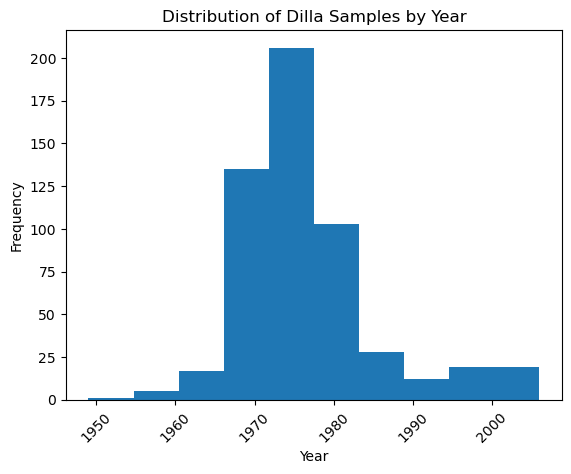

In [13]:
dillaSamples = dillaSamples.dropna(subset=['year'])

# Get the min and max of years
year_min = dillaSamples['year'].min()
year_max = dillaSamples['year'].max()
# Get the mean and median of the year column
year_mean = dillaSamples['year'].mean()
year_median = dillaSamples['year'].median()

print("Year min:", year_min)
print("Year max:", year_max)
print("Year mean:", year_mean)
print("Year median:", year_median)

# Create the histogram
plt.hist(dillaSamples['year'])

# Set the title and axis labels
plt.title('Distribution of Dilla Samples by Year')
plt.xlabel('Year')
plt.ylabel('Frequency')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Display the histogram
plt.show()

Tempo min: 0.0
Tempo max: 217.588
Tempo mean: 113.65048987108656
Tempo median: 109.695


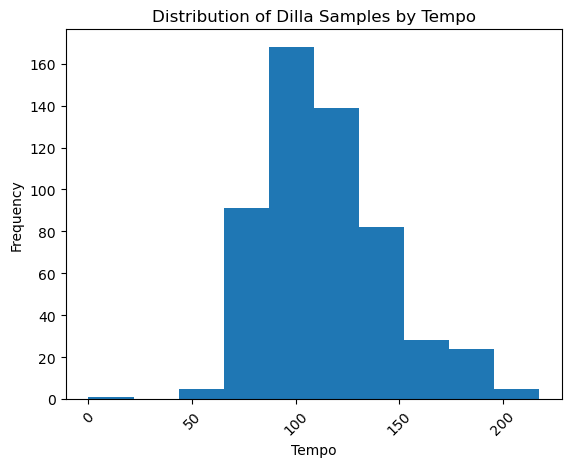

In [14]:
dillaSamples = dillaSamples.dropna(subset=['tempo'])

# Get the min and max of tempo
tempo_min = dillaSamples['tempo'].min()
tempo_max = dillaSamples['tempo'].max()
# Get the mean and median of the year column
tempo_mean = dillaSamples['tempo'].mean()
tempo_median = dillaSamples['tempo'].median()

print("Tempo min:", tempo_min)
print("Tempo max:", tempo_max)
print("Tempo mean:", tempo_mean)
print("Tempo median:", tempo_median)

# Create the histogram
plt.hist(dillaSamples['tempo'])

# Set the title and axis labels
plt.title('Distribution of Dilla Samples by Tempo')
plt.xlabel('Tempo')
plt.ylabel('Frequency')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Display the histogram
plt.show()

Acousticness min: 3.35e-06
Acousticness max: 0.996
Acousticness mean: 0.41490197780847143
Acousticness median: 0.334


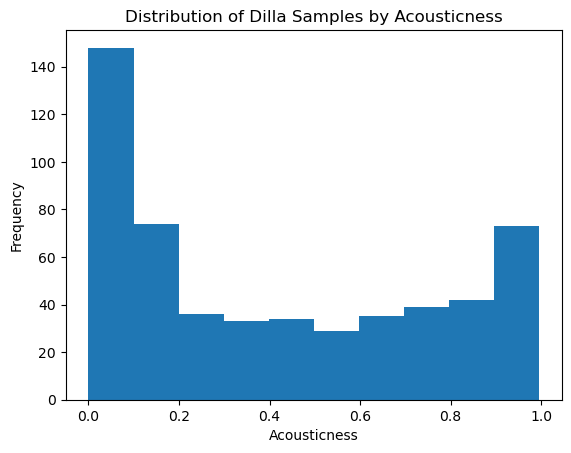

In [15]:
# Drop rows with missing values in the specified columns
dillaSamples = dillaSamples.dropna(subset=['acousticness'])

# Get the min and max of acousticness
acousticness_min = dillaSamples['acousticness'].min()
acousticness_max = dillaSamples['acousticness'].max()
# Get the mean and median of the acousticness column
acousticness_mean = dillaSamples['acousticness'].mean()
acousticness_median = dillaSamples['acousticness'].median()

print("Acousticness min:", acousticness_min)
print("Acousticness max:", acousticness_max)
print("Acousticness mean:", acousticness_mean)
print("Acousticness median:", acousticness_median)

# Create the histogram
plt.hist(dillaSamples['acousticness'])

# Set the title and axis labels
plt.title('Distribution of Dilla Samples by Acousticness')
plt.xlabel('Acousticness')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

 'acousticness', 'danceability', 'energy', 'instrumentalness', ,
       'liveness', 'loudness', 'mode', 'speechiness', 'valence', 'song_popularity',  'genres'

Danceability min: 0.0
Danceability max: 0.988
Danceability mean: 0.5488657458563535
Danceability median: 0.56


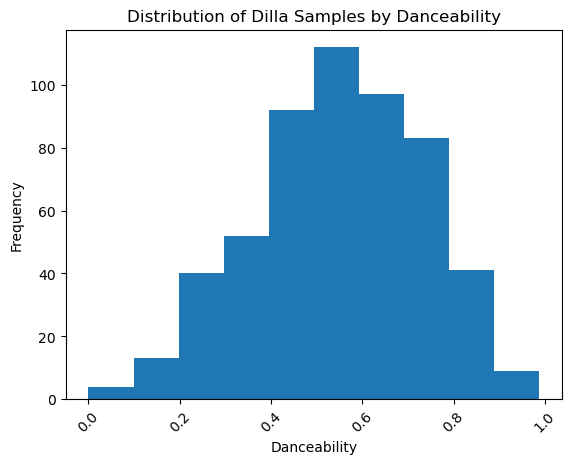

In [16]:
dillaSamples = dillaSamples.dropna(subset=['danceability'])

# Get the min and max of danceability
danceability_min = dillaSamples['danceability'].min()
danceability_max = dillaSamples['danceability'].max()
# Get the mean and median of the danceability column
danceability_mean = dillaSamples['danceability'].mean()
danceability_median = dillaSamples['danceability'].median()

print("Danceability min:", danceability_min)
print("Danceability max:", danceability_max)
print("Danceability mean:", danceability_mean)
print("Danceability median:", danceability_median)

# Create the histogram
plt.hist(dillaSamples['danceability'])

# Set the title and axis labels
plt.title('Distribution of Dilla Samples by Danceability')
plt.xlabel('Danceability')
plt.ylabel('Frequency')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Display the histogram
plt.show()

Energy min: 0.00495
Energy max: 0.991
Energy mean: 0.4922976795580111
Energy median: 0.484


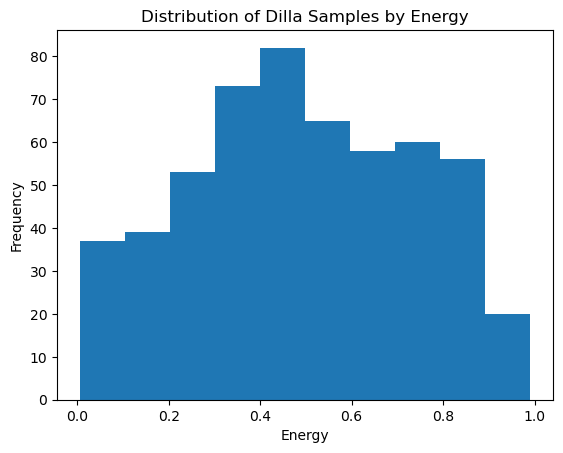

In [17]:
dillaSamples = dillaSamples.dropna(subset=['energy'])

# Get the min and max of energy
energy_min = dillaSamples['energy'].min()
energy_max = dillaSamples['energy'].max()
# Get the mean and median of the energy column
energy_mean = dillaSamples['energy'].mean()
energy_median = dillaSamples['energy'].median()

print("Energy min:", energy_min)
print("Energy max:", energy_max)
print("Energy mean:", energy_mean)
print("Energy median:", energy_median)

# Create the histogram
plt.hist(dillaSamples['energy'])

# Set the title and axis labels
plt.title('Distribution of Dilla Samples by Energy')
plt.xlabel('Energy')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

Instrumentalness min: 0.0
Instrumentalness max: 0.993
Instrumentalness mean: 0.27212644241252304
Instrumentalness median: 0.0156


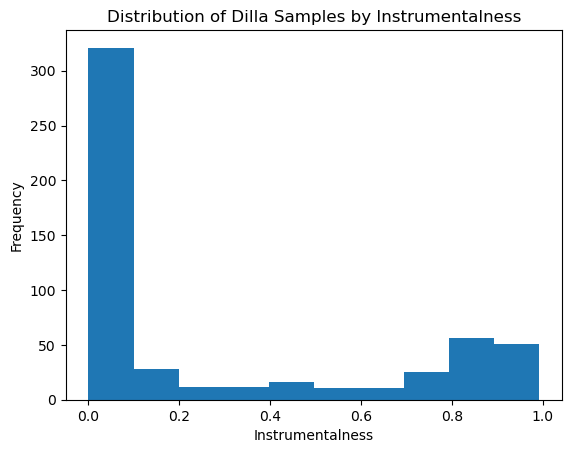

In [18]:
dillaSamples = dillaSamples.dropna(subset=['instrumentalness'])

# Get the min and max of instrumentalness
instrumentalness_min = dillaSamples['instrumentalness'].min()
instrumentalness_max = dillaSamples['instrumentalness'].max()
# Get the mean and median of the instrumentalness column
instrumentalness_mean = dillaSamples['instrumentalness'].mean()
instrumentalness_median = dillaSamples['instrumentalness'].median()

print("Instrumentalness min:", instrumentalness_min)
print("Instrumentalness max:", instrumentalness_max)
print("Instrumentalness mean:", instrumentalness_mean)
print("Instrumentalness median:", instrumentalness_median)

# Create the histogram
plt.hist(dillaSamples['instrumentalness'])

# Set the title and axis labels
plt.title('Distribution of Dilla Samples by Instrumentalness')
plt.xlabel('Instrumentalness')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

Liveness min: 0.0277
Liveness max: 0.975
Liveness mean: 0.1831948434622468
Liveness median: 0.117


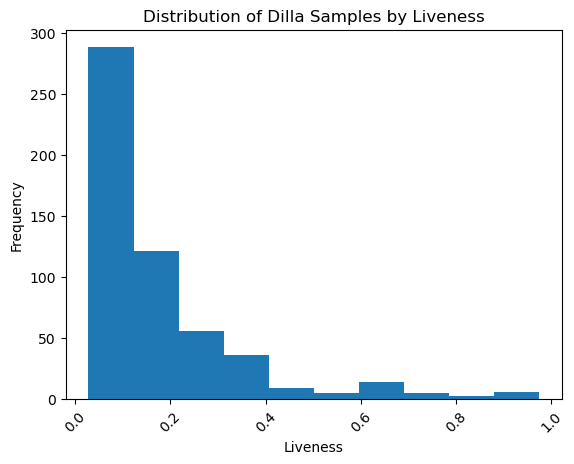

In [19]:
dillaSamples = dillaSamples.dropna(subset=['liveness'])

# Get the min and max of liveness
liveness_min = dillaSamples['liveness'].min()
liveness_max = dillaSamples['liveness'].max()
# Get the mean and median of the liveness column
liveness_mean = dillaSamples['liveness'].mean()
liveness_median = dillaSamples['liveness'].median()

print("Liveness min:", liveness_min)
print("Liveness max:", liveness_max)
print("Liveness mean:", liveness_mean)
print("Liveness median:", liveness_median)

# Create the histogram
plt.hist(dillaSamples['liveness'])

# Set the title and axis labels
plt.title('Distribution of Dilla Samples by Liveness')
plt.xlabel('Liveness')
plt.ylabel('Frequency')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Display the histogram
plt.show()

Loudness min: -30.4
Loudness max: -2.654
Loudness mean: -12.333456721915285
Loudness median: -11.385


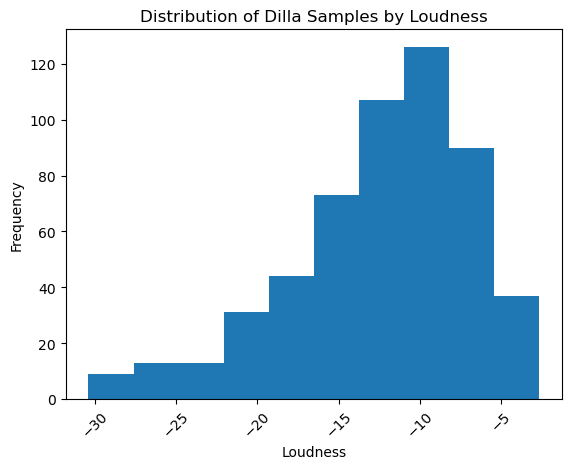

In [20]:
# Drop rows with missing values in the 'loudness' column
dillaSamples = dillaSamples.dropna(subset=['loudness'])

# Get the min and max of loudness
loudness_min = dillaSamples['loudness'].min()
loudness_max = dillaSamples['loudness'].max()
# Get the mean and median of the loudness column
loudness_mean = dillaSamples['loudness'].mean()
loudness_median = dillaSamples['loudness'].median()

print("Loudness min:", loudness_min)
print("Loudness max:", loudness_max)
print("Loudness mean:", loudness_mean)
print("Loudness median:", loudness_median)

# Create the histogram
plt.hist(dillaSamples['loudness'])

# Set the title and axis labels
plt.title('Distribution of Dilla Samples by Loudness')
plt.xlabel('Loudness')
plt.ylabel('Frequency')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Display the histogram
plt.show()


Mode min: 0.0
Mode max: 1.0
Mode mean: 0.5506445672191529
Mode median: 1.0


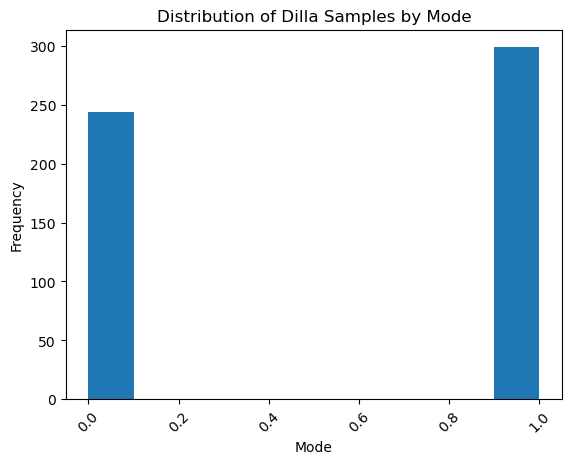

In [21]:
# Get the min and max of mode
mode_min = dillaSamples['mode'].min()
mode_max = dillaSamples['mode'].max()
# Get the mean and median of the mode column
mode_mean = dillaSamples['mode'].mean()
mode_median = dillaSamples['mode'].median()

print("Mode min:", mode_min)
print("Mode max:", mode_max)
print("Mode mean:", mode_mean)
print("Mode median:", mode_median)

# Create the histogram
plt.hist(dillaSamples['mode'])

# Set the title and axis labels
plt.title('Distribution of Dilla Samples by Mode')
plt.xlabel('Mode')
plt.ylabel('Frequency')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Display the histogram
plt.show()


Speechiness min: 0.0
Speechiness max: 0.869
Speechiness mean: 0.08201012891344384
Speechiness median: 0.0456


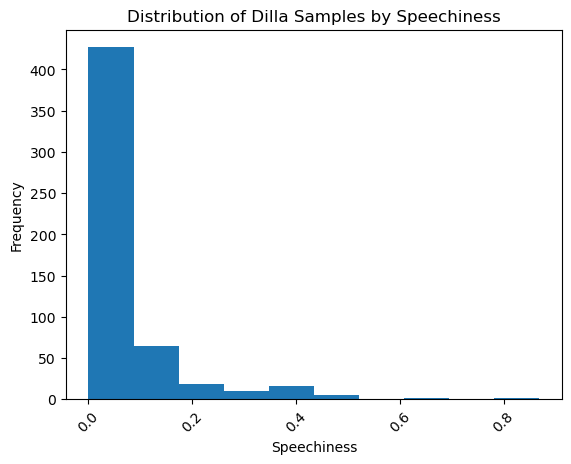

In [22]:
# Drop rows with missing values for speechiness
dillaSamples = dillaSamples.dropna(subset=['speechiness'])

# Get the min and max of speechiness
speechiness_min = dillaSamples['speechiness'].min()
speechiness_max = dillaSamples['speechiness'].max()
# Get the mean and median of the speechiness column
speechiness_mean = dillaSamples['speechiness'].mean()
speechiness_median = dillaSamples['speechiness'].median()

print("Speechiness min:", speechiness_min)
print("Speechiness max:", speechiness_max)
print("Speechiness mean:", speechiness_mean)
print("Speechiness median:", speechiness_median)

# Create the histogram
plt.hist(dillaSamples['speechiness'])

# Set the title and axis labels
plt.title('Distribution of Dilla Samples by Speechiness')
plt.xlabel('Speechiness')
plt.ylabel('Frequency')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Display the histogram
plt.show()


Valence min: 0.0
Valence max: 0.976
Valence mean: 0.5133162062615102
Valence median: 0.54


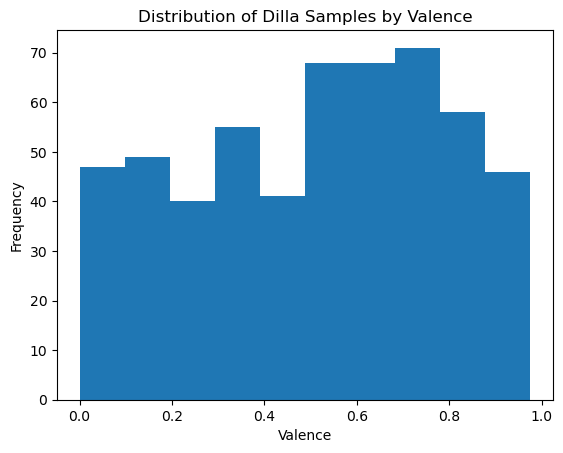

In [23]:
# Drop any rows with missing values for valence
dillaSamples = dillaSamples.dropna(subset=['valence'])

# Get the min and max of valence
valence_min = dillaSamples['valence'].min()
valence_max = dillaSamples['valence'].max()

# Get the mean and median of valence
valence_mean = dillaSamples['valence'].mean()
valence_median = dillaSamples['valence'].median()

print("Valence min:", valence_min)
print("Valence max:", valence_max)
print("Valence mean:", valence_mean)
print("Valence median:", valence_median)

# Create the histogram
plt.hist(dillaSamples['valence'])

# Set the title and axis labels
plt.title('Distribution of Dilla Samples by Valence')
plt.xlabel('Valence')
plt.ylabel('Frequency')

# Display the histogram
plt.show()


Song popularity min: 0.0
Song popularity max: 83.0
Song popularity mean: 38.714548802946595
Song popularity median: 40.0


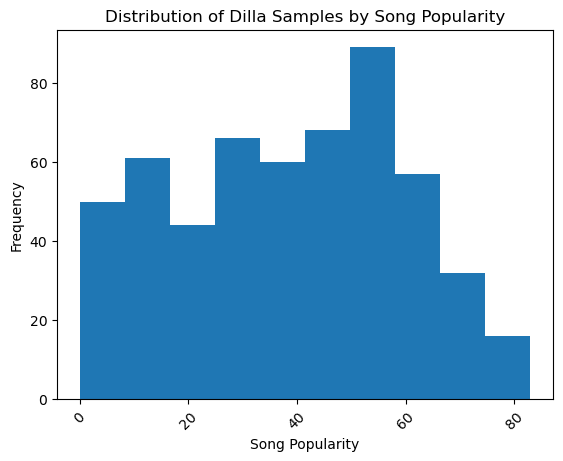

In [24]:
dillaSamples = dillaSamples.dropna(subset=['song_popularity'])

# Get the min and max of song_popularity
song_popularity_min = dillaSamples['song_popularity'].min()
song_popularity_max = dillaSamples['song_popularity'].max()
# Get the mean and median of the song_popularity column
song_popularity_mean = dillaSamples['song_popularity'].mean()
song_popularity_median = dillaSamples['song_popularity'].median()

print("Song popularity min:", song_popularity_min)
print("Song popularity max:", song_popularity_max)
print("Song popularity mean:", song_popularity_mean)
print("Song popularity median:", song_popularity_median)

# Create the histogram
plt.hist(dillaSamples['song_popularity'])

# Set the title and axis labels
plt.title('Distribution of Dilla Samples by Song Popularity')
plt.xlabel('Song Popularity')
plt.ylabel('Frequency')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Display the histogram
plt.show()


Key min: 0.0
Key max: 11.0
Key mean: 5.421731123388582
Key median: 5.0


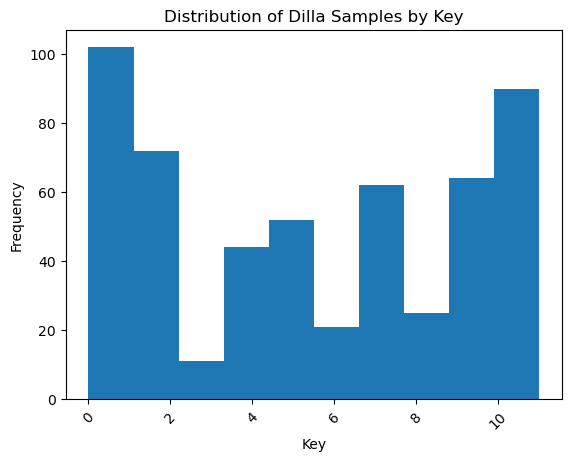

In [25]:
# Drop rows with missing values for key
dillaSamples = dillaSamples.dropna(subset=['key'])

# Get the min and max of key
key_min = dillaSamples['key'].min()
key_max = dillaSamples['key'].max()
# Get the mean and median of the key column
key_mean = dillaSamples['key'].mean()
key_median = dillaSamples['key'].median()

print("Key min:", key_min)
print("Key max:", key_max)
print("Key mean:", key_mean)
print("Key median:", key_median)

# Create the histogram
plt.hist(dillaSamples['key'])

# Set the title and axis labels
plt.title('Distribution of Dilla Samples by Key')
plt.xlabel('Key')
plt.ylabel('Frequency')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Display the histogram
plt.show()


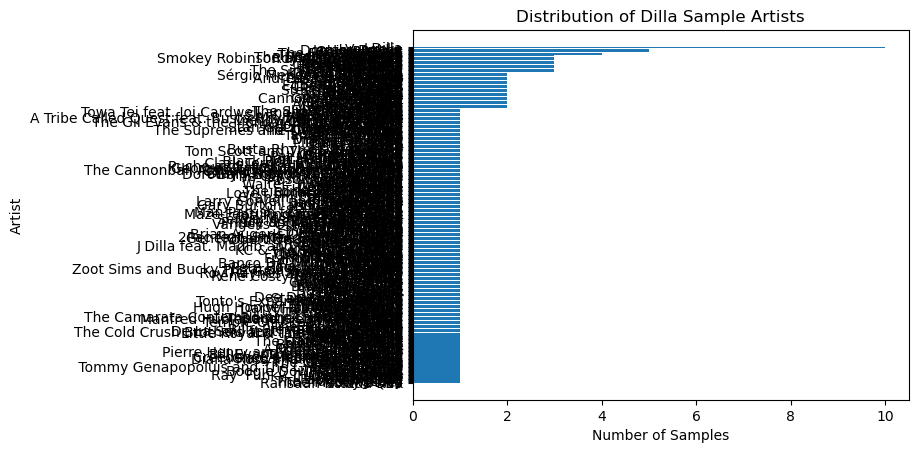

In [26]:
# Split the artists column on commas and explode to create new row for each artist
artist_counts = dillaSamples['artists'].str.split(',', expand=True).stack().reset_index(drop=True)

# Count the frequency of each artist
artist_counts = artist_counts.value_counts()

# Create the bar plot
plt.barh(artist_counts.index, artist_counts.values)

# Set the title and axis labels
plt.title('Distribution of Dilla Sample Artists')
plt.xlabel('Number of Samples')
plt.ylabel('Artist')

# Invert the y-axis to show most frequent artists at the top
plt.gca().invert_yaxis()

# Show the plot
plt.show()


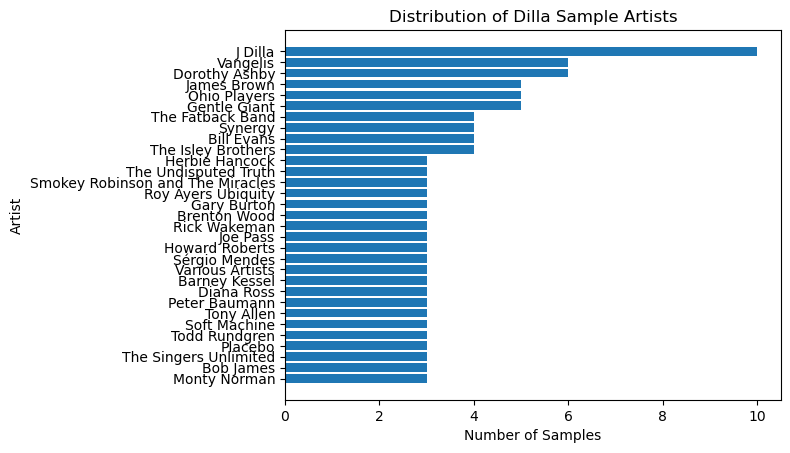

In [27]:
# Split the artists column on commas and explode to create new row for each artist
artist_counts = dillaSamples['artists'].str.split(',', expand=True).stack().reset_index(drop=True)

# Count the frequency of each artist
artist_counts = artist_counts.value_counts()

# Keep only the artists that were sampled more than once
artist_counts = artist_counts[artist_counts > 2]

# Create the bar plot
plt.barh(artist_counts.index, artist_counts.values)

# Set the title and axis labels
plt.title('Distribution of Dilla Sample Artists')
plt.xlabel('Number of Samples')
plt.ylabel('Artist')

# Invert the y-axis to show most frequent artists at the top
plt.gca().invert_yaxis()

# Show the plot
plt.show()


Top 10 artists sampled by Dilla in the dataset.

In [28]:
top_artists = dillaSamples['artists'].value_counts().head(10)
print(top_artists)

J Dilla               10
Vangelis               6
Dorothy Ashby          6
Ohio Players           5
Gentle Giant           5
James Brown            5
Synergy                4
Bill Evans             4
The Isley Brothers     4
The Fatback Band       4
Name: artists, dtype: int64


Top 10 most popular songs that Dilla sampled.

In [29]:
top_popularity = dillaSamples.groupby(['song_name', 'song_popularity', 'artists']).size().reset_index(name='count').sort_values(by='song_popularity', ascending=False)
top_popularity = top_popularity.head(10)
top_popularity = top_popularity.drop(columns=['count'])

print(top_popularity)

                                             song_name  song_popularity  \
531                                   You Belong to Me             83.0   
19                                   Ain't No Sunshine             82.0   
223       Is This What Feeling Gets? (Dorothy's Theme)             81.0   
365                  Put Your Love (In My Tender Care)             80.0   
220                                       Introduction             80.0   
318                              Never Gonna Come Down             80.0   
393                                 Send One Your Love             78.0   
212  In the Air Tonight (Ben Liebrand Extended Vers...             78.0   
424                                       Stay With Me             78.0   
271                                       Love at Last             77.0   

                                               artists  
531                                The Doobie Brothers  
19                                      Willis Jackson  
223

In [30]:
top_popularity = dillaSamples.groupby(['song_name', 'tempo', 'artists']).size().reset_index(name='count').sort_values(by='tempo', ascending=False)
top_popularity = top_popularity.head(10)
top_popularity = top_popularity.drop(columns=['count'])

print(top_popularity)

                                             song_name    tempo  \
111                                     Doowutchyalike  217.588   
510                                       Warm Weather  212.137   
515                                    What's Going On  201.960   
349                                           Paradise  199.241   
337                      One Note Samba / Spanish Flea  195.838   
37                                  Ashley's Roachclip  192.506   
175                                     Gotta Have You  190.077   
212  In the Air Tonight (Ben Liebrand Extended Vers...  189.507   
47   Basketball Throwdown\nStoop Rap\nFantastic Fre...  188.370   
491                       Time: The Donut of the Heart  186.788   

                           artists  
111            Digital Underground  
510  Larry Coryell and Brian Keane  
515                     Les McCann  
349                           Sade  
337     Sérgio Mendes & Brasil '66  
37              The Soul Searchers  
175